# Model calibration

## Necessary functions

In [1]:
from sklearn.calibration import calibration_curve
#average gap across all bins in a reliability diagram, weighted by the number of instances in each bin
from pycalib.metrics import binary_ECE
#1/N*sum((y_hat - y_true)^2)
from sklearn.metrics import brier_score_loss
#-1/N*sum(y_true*log(y_hat) + (1 - y_true*log(1 - y_hat)))
from sklearn.metrics import log_loss

def plot_calibration_curve(y_true, y_hat, name, title):
    """Plot calibration curve"""

    fig = plt.figure()
    ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan = 2)
    ax2 = plt.subplot2grid((4, 1), (3, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label= "Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(y_true, y_hat, n_bins = 10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label = f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc = "lower right")
    ax1.set_title(f'Calibration plot ({name})')
    
    ax2.hist(y_hat, range=(0, 1), bins = 10, label = name, histtype = "step", lw = 2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    
    fig.savefig(title, bbox_inches='tight', dpi=150)
    
def eval_cali(y_true, y_hat, name, title):
    plot_calibration_curve(y_true, y_hat, name, title)
    ECE = binary_ECE(y_true, y_hat)
    brier_loss = brier_score_loss(y_true, y_hat)
    ce_loss = log_loss(y_true, y_hat, eps = 1e-6)
    print("ECE: " + str(ECE))
    print("brier score: " + str(brier_loss))
    print("crossentropy loss: " + str(ce_loss))

In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from scipy.stats import chi2

def HosmerLemeshow(y_hat, y_true, bins):
    #sort the data
    inds = np.argsort(y_hat)
    y_hat = y_hat[inds]
    y_true = y_true[inds]
    binned = []
    
    #bin the data in equally-sized bins
    cuts = [i/bins for i in range(bins + 1)]
    binned_y_hat = [y_hat[int(np.round(cuts[i]*len(y_hat))):int(np.round(cuts[i + 1]*len(y_hat)))] for i in range(len(cuts) - 1)]
    binned_y_true = [y_true[int(np.round(cuts[i]*len(y_true))):int(np.round(cuts[i + 1]*len(y_true)))] for i in range(len(cuts) - 1)]

    H = 0
    eps = 0.001
    
    #calculate the hosmer statistic
    for i in range(bins):
        bin_len = len(binned_y_true[i])
        observed_1 = eps + sum(binned_y_true[i])
        expected_1 = eps + np.mean(binned_y_hat[i])*bin_len
        observed_0 = eps + bin_len - observed_1
        expected_0 = 2*eps + bin_len - expected_1
        
        H += (((observed_1 - expected_1)**2)/expected_1) + (((observed_0 - expected_0)**2)/expected_0)
        
    print(H)
    #determine the p-value
    pvalue = 1 - chi2.cdf(H, bins - 2)
    
    return pvalue, binned_y_hat, binned_y_true

In [149]:
"""
#can be used to make graphs of equally sized bins
mean_predicted_value = []
fraction_of_positives = []

for i in range(len(b_y_hat)):
    mean_predicted_value.append(np.mean(b_y_hat[i]))
    fraction_of_positives.append(sum(b_y_true[i])/len(b_y_true[i]))
    
#adapted version of the kolmogorov-smirnof statistical test
from scipy.stats import ks_2samp
ks_2samp(mean_predicted_value, fraction_of_positives)

#plot calibration curve with equally sized bins
plt.scatter(mean_predicted_value, fraction_of_positives)
plt.xlabel("mean predicted values")
plt.ylabel("fraction of positives")
plt.title("uncalibrated")
"""

'\n#can be used to make graphs of equally sized bins\nmean_predicted_value = []\nfraction_of_positives = []\n\nfor i in range(len(b_y_hat)):\n    mean_predicted_value.append(np.mean(b_y_hat[i]))\n    fraction_of_positives.append(sum(b_y_true[i])/len(b_y_true[i]))\n    \n#adapted version of the kolmogorov-smirnof statistical test\nfrom scipy.stats import ks_2samp\nks_2samp(mean_predicted_value, fraction_of_positives)\n\n#plot calibration curve with equally sized bins\nplt.scatter(mean_predicted_value, fraction_of_positives)\nplt.xlabel("mean predicted values")\nplt.ylabel("fraction of positives")\nplt.title("uncalibrated")\n'

## Load y_hat and y_true data

In [3]:
y_hat_test = np.load('/home/yarivl/thesis/results/ConvNeXt/HX1/y_hat_test.npy')
y_true_test = np.load('/home/yarivl/thesis/results/ConvNeXt/HX1/y_true_test.npy')
y_hat_val = np.load('/home/yarivl/thesis/results/ConvNeXt/HX1/y_hat_val.npy')
y_true_val = np.load('/home/yarivl/thesis/results/ConvNeXt/HX1/y_true_val.npy')

## Evaluate uncalibrated validation set

In [4]:
p_val, b_y_hat, b_y_true = HosmerLemeshow(y_hat_val, y_true_val, 10)

392.7282303002878


In [5]:
p_val

0.0

ECE: 0.0015350970425194424
brier score: 0.02583243439908291
crossentropy loss: 0.09110552919411238


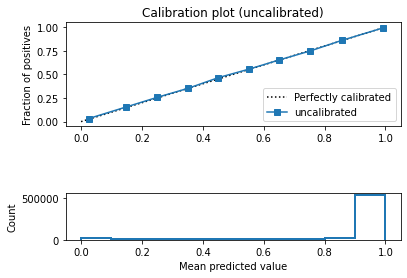

In [7]:
eval_cali(y_true_val, y_hat_val, "uncalibrated", "t_hx1_val_uncal.png")

## Evaluate calibrated validation set

### Isotonic regression

In [8]:
from sklearn.isotonic import IsotonicRegression

iso_reg = IsotonicRegression(out_of_bounds = 'clip').fit(y_hat_val, y_true_val)
y_cal_val_isotonic = iso_reg.predict(y_hat_val)

In [9]:
p_val_iso, b_y_hat_iso, b_y_true_iso = HosmerLemeshow(y_cal_val_isotonic, y_true_val, 10)

0.4187461593670912


In [10]:
p_val_iso

0.9999322381333509

ECE: 7.259700880027898e-07
brier score: 0.025788726522880067
crossentropy loss: 0.09059362661001229


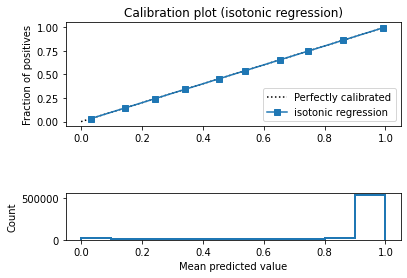

In [11]:
eval_cali(y_true_val, y_cal_val_isotonic, "isotonic regression", "t_hx1_val_iso.png")

### Platt scaling

In [12]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression().fit(y_hat_val.reshape(-1, 1), y_true_val)
y_cal_val_logistic = log_reg.predict(y_hat_val.reshape(-1, 1))

In [13]:
p_val_log, b_y_hat_log, b_y_true_log = HosmerLemeshow(y_cal_val_logistic, y_true_val, 10)

24413548220.90017


In [14]:
p_val_log

0.0

ECE: 0.03528445924739943
brier score: 0.03528446563116903
crossentropy loss: 0.4871551637860206


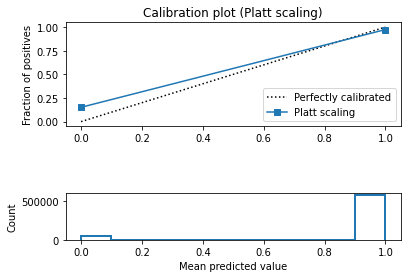

In [15]:
eval_cali(y_true_val, y_cal_val_logistic, "Platt scaling", "t_hx1_val_pla.png")

## Evaluate uncalibrated test set

In [16]:
p_test, b_y_hat_test, b_y_true_test = HosmerLemeshow(y_hat_test, y_true_test, 10)

262.25142388515314


In [17]:
p_test

0.0

ECE: 0.0019101205599762522
brier score: 0.02614984823470129
crossentropy loss: 0.0913845926054415


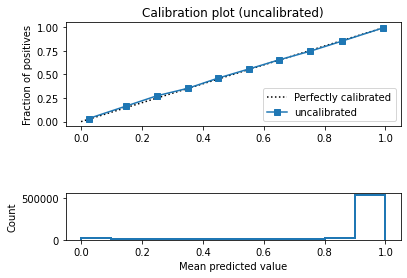

In [18]:
eval_cali(y_true_test, y_hat_test, "uncalibrated", "t_hx1_test_uncal.png")

## Evaluate calibrated test set

### Isotonic regression

In [19]:
y_cal_test_isotonic = iso_reg.predict(y_hat_test)

In [20]:
p_test_iso, b_y_hat_iso_test, b_y_true_iso_test = HosmerLemeshow(y_cal_test_isotonic, y_true_test, 10)

29.94972297914865


In [21]:
p_test_iso

0.0002157478707260907

ECE: 0.0007300804235208037
brier score: 0.026148754940781616
crossentropy loss: 0.09120710384598363


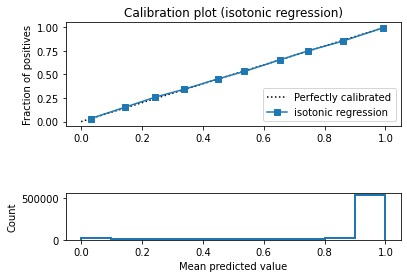

In [22]:
eval_cali(y_true_test, y_cal_test_isotonic, "isotonic regression", "t_hx1_test_iso.png")

### Platt scaling

In [23]:
y_cal_test_logistic = log_reg.predict(y_hat_test.reshape(-1, 1))

In [24]:
p_test_log, b_y_hat_log, b_y_true_log = HosmerLemeshow(y_cal_test_logistic, y_true_test, 10)

24842973022.46219


In [25]:
p_test_log

0.0

ECE: 0.03583744831363789
brier score: 0.03583746977217767
crossentropy loss: 0.4947908375687343


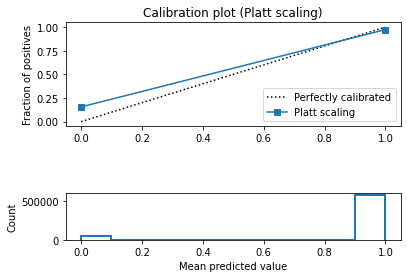

In [26]:
eval_cali(y_true_test, y_cal_test_logistic, "Platt scaling", "t_hx1_test_pla.png")

## Store new calibrated test values

In [27]:
np.save('/home/yarivl/thesis/results/ConvNeXt/HX1/y_cal_test_isotonic.npy', y_cal_test_isotonic)

In [29]:
#dataset and model architectures
from WGBSDataset import WGBSDataset
from NSDataset6 import NSDataset
from TCN_model import TCN_model
from ConvNeXt_model112 import ConvNeXt_model
from Transformer_model_window16 import Transformer_model

#other modules and packages
import os
import numpy as np
import h5py
import math
import torch
import pandas as pd
from torch import split
from time import time
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn import metrics
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pytorch_lightning as pl
import torchmetrics
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import average_precision_score
import random

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [30]:
#calculate precision, recall, false positive rate, true positive rate
fpr, tpr, thresholds_ROC = roc_curve(y_true_test, y_hat_test)
precision, recall, thresholds_PR = precision_recall_curve(y_true_test, y_hat_test)

#calculate area under the curve
AUC_ROC = metrics.auc(fpr, tpr)
AUC_PR = average_precision_score(y_true_test, y_hat_test)
print("AUC_ROC: " + str(AUC_ROC))
print("AUC_PR: " + str(AUC_PR))


AUC_ROC: 0.9789308819431108
AUC_PR: 0.9976641097403222


In [33]:
acc = accuracy_score(y_true_test, np.round(y_hat_test))
prec = precision_score(y_true_test, np.round(y_hat_test))
rec = recall_score(y_true_test, np.round(y_hat_test))

In [34]:
print("accuracy: " + str(acc))
print("precision: " + str(prec))
print("recall: " + str(rec))

accuracy: 0.9642898052691867
precision: 0.9750852496208737
recall: 0.9861221121824946


In [97]:
#calculate precision, recall, false positive rate, true positive rate
fpr, tpr, thresholds_ROC = roc_curve(y_true_test, y_cal_test_isotonic)
precision, recall, thresholds_PR = precision_recall_curve(y_true_test, y_cal_test_isotonic)

#calculate area under the curve
AUC_ROC = metrics.auc(fpr, tpr)
AUC_PR = average_precision_score(y_true_test, y_cal_test_isotonic)
print("AUC_ROC: " + str(AUC_ROC))
print("AUC_PR: " + str(AUC_PR))


AUC_ROC: 0.993325834190382
AUC_PR: 0.9917748773987703


In [98]:
acc = accuracy_score(y_true_test, np.round(y_cal_test_isotonic))
prec = precision_score(y_true_test, np.round(y_cal_test_isotonic))
rec = recall_score(y_true_test, np.round(y_cal_test_isotonic))

In [99]:
print("accuracy: " + str(acc))
print("precision: " + str(prec))
print("recall: " + str(rec))

accuracy: 0.9521761151720555
precision: 0.9426752878110658
recall: 0.9424801031333173


In [36]:
fpr, tpr, thresholds_ROC = roc_curve(y_true_test, y_cal_test_isotonic)
precision, recall, thresholds_PR = precision_recall_curve(y_true_test, y_cal_test_isotonic)

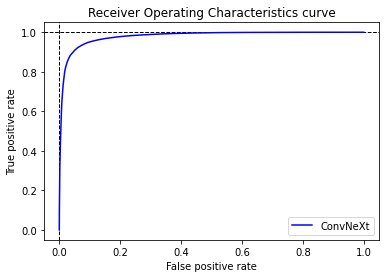

In [45]:
fig, ax = plt.subplots()
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('Receiver Operating Characteristics curve')
ax.axvline(x = 0, color='black', linestyle='--', linewidth = 1)
ax.axhline(y = 1, color='black', linestyle='--', linewidth = 1)
plt.ylim(-0.05, 1.05)
ax.plot(fpr, tpr, "b-", label = f'{"ConvNeXt"}')
ax.legend(loc = "lower right")

fig.savefig("roc_hx1", bbox_inches='tight', dpi=150)

plt.show()

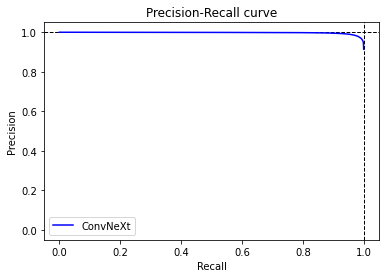

In [46]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.ylim(-0.05, 1.05)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall curve')
ax.axvline(x = 1, color='black', linestyle='--', linewidth = 1)
ax.axhline(y = 1, color='black', linestyle='--', linewidth = 1)
ax.plot(recall, precision, "b-", label = f'{"ConvNeXt"}')
#ax.plot(recall[:1935769], thresholds_PR, color = 'orange')
ax.legend(loc = "lower left")

fig.savefig("pr_hx1", bbox_inches='tight', dpi=150)

plt.show()

In [47]:
y_hat_test_t = np.load('/home/yarivl/thesis/results/Transformer/E_coli/y_cal_test_isotonic.npy')
y_true_test = np.load('/home/yarivl/thesis/results/Transformer/E_coli/y_true_test.npy')
y_hat_test_c = np.load('/home/yarivl/thesis/results/ConvNeXt/E_coli/y_cal_test_isotonic.npy')

In [48]:
fpr1, tpr1, thresholds_ROC1 = roc_curve(y_true_test, y_hat_test_c)
fpr2, tpr2, thresholds_ROC2 = roc_curve(y_true_test, y_hat_test_t)

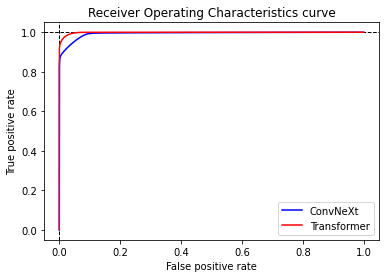

In [49]:
fig, ax = plt.subplots()
plt.ylim(-0.05, 1.05)
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('Receiver Operating Characteristics curve')
ax.axvline(x = 0, color='black', linestyle='--', linewidth = 1)
ax.axhline(y = 1, color='black', linestyle='--', linewidth = 1)
ax.plot(fpr1, tpr1, "b-", label = f'{"ConvNeXt"}')
ax.plot(fpr2, tpr2, "r-", label = f'{"Transformer"}')
ax.legend(loc = "lower right")

fig.savefig("roc_ecol", bbox_inches='tight', dpi=150)

plt.show()

In [50]:
precision1, recall1, thresholds_PR1 = precision_recall_curve(y_true_test, y_hat_test_c)
precision2, recall2, thresholds_PR2 = precision_recall_curve(y_true_test, y_hat_test_t)

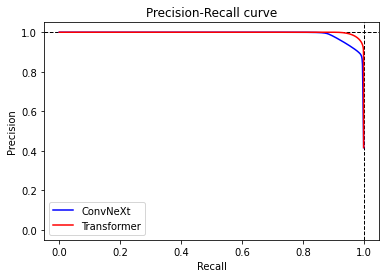

In [51]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.ylim(-0.05, 1.05)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall curve')
ax.axvline(x = 1, color='black', linestyle='--', linewidth = 1)
ax.axhline(y = 1, color='black', linestyle='--', linewidth = 1)
ax.plot(recall1, precision1, "b-", label = f'{"ConvNeXt"}')
ax.plot(recall2, precision2, "r-", label = f'{"Transformer"}')
#ax.plot(recall[:1935769], thresholds_PR, color = 'orange')
ax.legend(loc = "lower left")

fig.savefig("pr_ecol", bbox_inches='tight', dpi=150)

plt.show()